In [1]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform, shift
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import imageio
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import os

#TODO simulated volume, 
#TODOshare downscaled 2bm data
#TODOcheck algorithm if it can fix warping. 
#TODOadd micro-adjustment scroll bars for each axis (x,y,z)

In [2]:
def translate_to_origin(points):
    centroid = np.mean(points, axis=0)
    translated_points = points - centroid
    return translated_points, centroid

def scale_to_match(points1, points2):
    size1 = np.linalg.norm(points1[1] - points1[0])
    size2 = np.linalg.norm(points2[1] - points2[0])
    scale_factor = size2 / size1
    scaled_points1 = points1 * scale_factor
    return scaled_points1, scale_factor

def kabsch_algorithm(P, Q):
    C = np.dot(P.T, Q)
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        V[:, -1] = -V[:, -1]

    rotation_matrix = np.dot(V, W)
    return rotation_matrix

def align_triangles(triangle1, triangle2):
    # Step 1: Translate both triangles to origin
    translated_triangle1, centroid1 = translate_to_origin(triangle1)
    translated_triangle2, centroid2 = translate_to_origin(triangle2)
    
    # Step 2: Scale triangle1 to match the size of triangle2
    scaled_triangle1, scale_factor = scale_to_match(translated_triangle1, translated_triangle2)
    
    # Step 3: Find the optimal rotation using the Kabsch algorithm
    rotation_matrix = kabsch_algorithm(scaled_triangle1, translated_triangle2)
    
    # Apply the rotation to scaled_triangle1
    rotated_triangle1 = np.dot(scaled_triangle1, rotation_matrix)
    
    # Translate rotated_triangle1 back to the position of triangle2
    transformed_triangle1 = rotated_triangle1 + centroid2
    
    return transformed_triangle1, rotation_matrix, centroid2 - scale_factor * np.dot(centroid1, rotation_matrix), scale_factor, centroid1, centroid2


def rotation_matrix_to_euler_angles(R):
    assert R.shape == (3, 3), "Input rotation matrix must be 3x3"
    
    if R[2, 0] != 1 and R[2, 0] != -1:
        theta_y = -np.arcsin(R[2, 0])
        cos_theta_y = np.cos(theta_y)
        theta_x = np.arctan2(R[2, 1] / cos_theta_y, R[2, 2] / cos_theta_y)
        theta_z = np.arctan2(R[1, 0] / cos_theta_y, R[0, 0] / cos_theta_y)
    else:
        # Gimbal lock case
        theta_z = 0
        if R[2, 0] == -1:
            theta_y = np.pi / 2
            theta_x = np.arctan2(R[0, 1], R[0, 2])
        else:
            theta_y = -np.pi / 2
            theta_x = np.arctan2(-R[0, 1], -R[0, 2])
    
    return theta_x, theta_y, theta_z

def rotation_matrix_from_angles(theta_x, theta_y, theta_z):
    theta_x = np.radians(theta_x)
    theta_y = np.radians(theta_y)
    theta_z = np.radians(theta_z)
    # Rotation matrix for the x-axis
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(theta_x), -np.sin(theta_x)],
        [0, np.sin(theta_x), np.cos(theta_x)]
    ])
    
    # Rotation matrix for the y-axis
    R_y = np.array([
        [np.cos(theta_y), 0, np.sin(theta_y)],
        [0, 1, 0],
        [-np.sin(theta_y), 0, np.cos(theta_y)]
    ])
    
    # Rotation matrix for the z-axis
    R_z = np.array([
        [np.cos(theta_z), -np.sin(theta_z), 0],
        [np.sin(theta_z), np.cos(theta_z), 0],
        [0, 0, 1]
    ])
    
    # Combined rotation matrix
    R = np.dot(R_z, np.dot(R_y, R_x))
    
    return R

def apply_rotation_matrix(image_stack, rotation_matrix):
    # Compute the center of the image stack
    center = np.array(image_stack.shape) / 2
    
    # Construct the affine transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = center - np.dot(rotation_matrix, center)
    
    # Apply the affine transformation
    rotated_image_stack = affine_transform(
        image_stack, 
        transformation_matrix[:3, :3], 
        offset=transformation_matrix[:3, 3],
        mode='nearest'
    )
    
    return rotated_image_stack

def visualize_image_stacks(original_stack, rotated_stack):
    fig, axes = plt.subplots(2, original_stack.shape[0], figsize=(15, 5))
    
    for i in range(original_stack.shape[0]):
        axes[0, i].imshow(original_stack[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original Slice {i+1}')
        
        axes[1, i].imshow(rotated_stack[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Rotated Slice {i+1}')

    plt.tight_layout()
    plt.show()

def visualize_triangles(triangles):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a Poly3DCollection for the triangles
    poly3d = [triangle for triangle in triangles]
    ax.add_collection3d(Poly3DCollection(poly3d, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.5))

    # Set the limits for the axes
    all_points = np.concatenate(triangles, axis=0)
    x_vals = all_points[:, 0]
    y_vals = all_points[:, 1]
    z_vals = all_points[:, 2]
    ax.set_xlim(min(x_vals), max(x_vals))
    ax.set_ylim(min(y_vals), max(y_vals))
    ax.set_zlim(min(z_vals), max(z_vals))

    # Label the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()
    
def visualize_image_stack(image_stack):
    # Initial slice index
    slice_index = 0

    # Create a figure and axis to plot the images
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.25)
    image_display = ax.imshow(image_stack[slice_index], cmap='gray')
    ax.set_title(f'Slice {slice_index}')

    # Create the slider axis and slider
    ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
    slider = Slider(ax_slider, 'Slice', 0, image_stack.shape[0] - 1, valinit=slice_index, valfmt='%0.0f')

    def update(val):
        slice_index = int(slider.val)
        image_display.set_data(image_stack[slice_index])
        ax.set_title(f'Slice {slice_index}')
        fig.canvas.draw_idle()

    slider.on_changed(update)

    plt.show()


def animate_plot_triangles(triangle1, transformed_triangle1, triangle2, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create Poly3DCollection objects for the triangles
    poly1 = Poly3DCollection([triangle1], facecolors='red', edgecolors='r', alpha=0.5, label='Original Triangle 1')
    poly_trans = Poly3DCollection([transformed_triangle1], facecolors='blue', edgecolors='b', alpha=0.5, label='Transformed Triangle 1')
    poly2 = Poly3DCollection([triangle2], facecolors='green', edgecolors='g', alpha=0.5, label='Triangle 2')
    
    ax.add_collection3d(poly1)
    ax.add_collection3d(poly_trans)
    ax.add_collection3d(poly2)

    # Combine all points to set the axis limits
    all_points = np.concatenate([triangle1, transformed_triangle1, triangle2], axis=0)
    x_vals = all_points[:, 0]
    y_vals = all_points[:, 1]
    z_vals = all_points[:, 2]

    ax.set_xlim([min(x_vals), max(x_vals)])
    ax.set_ylim([min(y_vals), max(y_vals)])
    ax.set_zlim([min(z_vals), max(z_vals)])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    # Animation function
    def update(num):
        ratio = num / 100
        trans_points = (1 - ratio) * triangle1 + ratio * transformed_triangle1
        
        # Update the vertices of the transformed triangle
        poly_trans.set_verts([trans_points])
        
        # Rotate the plot view
        ax.view_init(elev=30, azim=num * 0.9)
        
        return poly_trans,

    ani = FuncAnimation(fig, update, frames=101, interval=10, blit=False)

    # Save animation as GIF
    ani.save(filename, writer=PillowWriter(fps=20))
    plt.show()
    
def animate_image_triangles(triangle1, transformed_triangle1, triangle2, image1, image2, filename):
    fig = plt.figure(figsize=(12, 6))
    
    # 3D plot for triangles
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Create Poly3DCollection objects for the triangles
    poly1 = Poly3DCollection([triangle1], facecolors='red', edgecolors='r', alpha=0.5, label='Original Triangle 1')
    poly_trans = Poly3DCollection([transformed_triangle1], facecolors='blue', edgecolors='b', alpha=0.5, label='Transformed Triangle 1')
    poly2 = Poly3DCollection([triangle2], facecolors='green', edgecolors='g', alpha=0.5, label='Triangle 2')
    
    ax1.add_collection3d(poly1)
    ax1.add_collection3d(poly_trans)
    ax1.add_collection3d(poly2)

    # Combine all points to set the axis limits
    all_points = np.concatenate([triangle1, transformed_triangle1, triangle2], axis=0)
    x_vals = all_points[:, 0]
    y_vals = all_points[:, 1]
    z_vals = all_points[:, 2]

    ax1.set_xlim([min(x_vals), max(x_vals)])
    ax1.set_ylim([min(y_vals), max(y_vals)])
    ax1.set_zlim([min(z_vals), max(z_vals)])

    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.legend()

    # 2D plot for images
    ax2 = fig.add_subplot(122)
    ax2.set_title('Overlayed Images')
    ax2.axis('off')

    # Initial plot objects for images
    img1 = ax2.imshow(image1, cmap='gray', alpha=0.5, extent=(0, image1.shape[1], image1.shape[0], 0))
    img2 = ax2.imshow(image2, cmap='gray', alpha=0.5, extent=(0, image2.shape[1], image2.shape[0], 0))

    # Animation function
    def update(num):
        ratio = num / 100
        trans_points = (1 - ratio) * triangle1 + ratio * transformed_triangle1
        
        # Update the vertices of the transformed triangle
        poly_trans.set_verts([trans_points])
        
        # Calculate the bounding box of the transformed triangle
        xmin, xmax = np.min(trans_points[:, 0]), np.max(trans_points[:, 0])
        ymin, ymax = np.min(trans_points[:, 1]), np.max(trans_points[:, 1])
        
        # Update the position of images
        img1.set_extent((xmin, xmax, ymin, ymax))
        img2.set_extent((xmin, xmax, ymin, ymax))
        
        # Rotate the plot view in 3D
        ax1.view_init(elev=30, azim=num * 0.9)
        
        return poly_trans, img1, img2

    ani = FuncAnimation(fig, update, frames=101, interval=10, blit=False)

    # Save animation as GIF
    ani.save(filename, writer=PillowWriter(fps=20))

    plt.tight_layout()
    plt.show()

def apply_translation_to_image_stack(array, axis_0, axis_1, axis_2):
    shifted_array = np.roll(array, shift=axis_0, axis=0)
    shifted_array = np.roll(shifted_array, shift=axis_1, axis=1)
    shifted_array = np.roll(shifted_array, shift=axis_2, axis=2)
    return shifted_array


def visualize_image_stack_side_by_side(image_stack, n_slices=5):
    # Initial slice index
    slice_index = 0

    # Create a figure and axes to plot the images
    fig, axes = plt.subplots(1, n_slices, figsize=(15, 5))
    plt.subplots_adjust(left=0.1, bottom=0.25, right=0.9, top=0.9, wspace=0.5)

    # Initialize the displayed images
    image_displays = []
    for i in range(n_slices):
        ax = axes[i]
        if i < image_stack.shape[0]:
            img = ax.imshow(image_stack[slice_index + i], cmap='gray')
            ax.set_title(f'Slice {slice_index + i}')
        else:
            img = ax.imshow(np.zeros_like(image_stack[0]), cmap='gray')
            ax.set_title('Empty Slice')
        image_displays.append(img)

    # Create the slider axis and slider
    ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
    slider = Slider(ax_slider, 'Slice', 0, image_stack.shape[0] - n_slices, valinit=slice_index, valfmt='%0.0f')

    def update(val):
        slice_index = int(slider.val)
        for i in range(n_slices):
            if slice_index + i < image_stack.shape[0]:
                image_displays[i].set_data(image_stack[slice_index + i])
                axes[i].set_title(f'Slice {slice_index + i}')
            else:
                image_displays[i].set_data(np.zeros_like(image_stack[0]))
                axes[i].set_title('Empty Slice')
        fig.canvas.draw_idle()

    slider.on_changed(update)

    plt.show()

def visualize_image_stack_all_at_once(image_stack, centroid=None):
    num_slices = image_stack.shape[0]
    num_cols = 5
    num_rows = int(np.ceil(num_slices / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
    axes = axes.flatten()

    for i in range(num_slices):
        ax = axes[i]
        ax.imshow(image_stack[i], cmap='gray')
        ax.set_title(f'Slice {i}')
        ax.axis('off')
        if i == num_slices//2:
            ax.scatter(image_stack.shape[2]//2, image_stack.shape[1]//2,image_stack.shape[0]//2, c='r', marker='o')
        if centroid is not None:
            if i == centroid[0]:
                ax.scatter(centroid[2], centroid[1], centroid[0], c='b', marker='o')

    # Turn off any unused axes
    for i in range(num_slices, len(axes)):
        axes[i].axis('off')


    plt.tight_layout()
    plt.show()

def visualize_image_with_scatter(image, points=None, title="Image", cmap='gray', marker_size=100):
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')  # Hide the axis
    
    if points is not None:
        # Extract x and y coordinates from the points list
        x_coords, y_coords = zip(*points)
        # Overlay the scatter plot with specified marker size
        plt.scatter(x_coords, y_coords, c='r', marker='o', s=marker_size)
    
    plt.show()

# Example usage
import numpy as np

def insert_array_in_center(larger_array, smaller_array):
    # Calculate the starting indices to insert the smaller array
    start_indices = np.array([(l - s) // 2 for l, s in zip(larger_array.shape, smaller_array.shape)])
    
    # Calculate the ending indices
    end_indices = start_indices + smaller_array.shape
    
    # Insert the smaller array into the larger array
    larger_array[start_indices[0]:end_indices[0], 
                 start_indices[1]:end_indices[1], 
                 start_indices[2]:end_indices[2]] = smaller_array
    
    return larger_array


def extract_plane_from_volume(volume, triangle):
    """
    Extract a 2D image from a 3D volume using coordinates from a triangle to define the plane.

    Parameters:
    volume (numpy.ndarray): The 3D volume from which to extract the image.
    triangle (numpy.ndarray): A 3x3 array defining the coordinates of the triangle's vertices.

    Returns:
    numpy.ndarray: The extracted 2D image.
    """
    # Define the vertices of the triangle
    p1, p2, p3 = triangle

    # Define the plane normal vector
    normal = np.cross(p2 - p1, p3 - p1)
    normal = normal / np.linalg.norm(normal)

    # Define a grid for the plane
    grid_size = 100  # Change this value to increase or decrease the resolution of the extracted image
    u = np.linspace(0, 1, grid_size)
    v = np.linspace(0, 1, grid_size)
    uu, vv = np.meshgrid(u, v)

    # Define the points on the plane
    points_on_plane = p1 + uu[:, :, np.newaxis] * (p2 - p1) + vv[:, :, np.newaxis] * (p3 - p1)

    # Define the interpolator for the volume
    z, y, x = np.arange(volume.shape[0]), np.arange(volume.shape[1]), np.arange(volume.shape[2])
    interpolator = RegularGridInterpolator((z, y, x), volume, method='linear', bounds_error=False, fill_value=0)

    # Interpolate the volume data onto the plane
    interpolated_values = interpolator(points_on_plane)

    return interpolated_values
def triangle_centroid(triangle):
    ax1 = np.mean(triangle[:,0])
    ax2 = np.mean(triangle[:,1])
    ax3 = np.mean(triangle[:,2])

    centroid = np.array([ax1, ax2, ax3])
    return centroid
def centered_coordinates(triangle):
    centroid = triangle_centroid(triangle)
    centered = triangle - centroid
    return centered

def rescale_dimensions(triangleA, triangleB, AmatchB=False):
    size1 = np.linalg.norm(triangleA[1] - triangleA[0])
    size2 = np.linalg.norm(triangleB[1] - triangleB[0])
    scale_factor = size2 / size1
    if AmatchB:
        scaled_points = triangleA * scale_factor
    else: 
        scaled_points = triangleB / scale_factor
    return scaled_points, scale_factor
def overlay_images(image1, image2, channel1='red', channel2='green'):
    """
    Overlay two grayscale images with specified color channels.

    Parameters:
    image1 (numpy.ndarray): The first image (2D array).
    image2 (numpy.ndarray): The second image (2D array).
    channel1 (str): Color channel for the first image ('red', 'green', or 'blue').
    channel2 (str): Color channel for the second image ('red', 'green', or 'blue').

    Returns:
    numpy.ndarray: The overlaid RGB image.
    """
    # Ensure both images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Both images must have the same dimensions")
    
    # Create an empty RGB image
    height, width = image1.shape
    overlay = np.zeros((height, width, 3), dtype=np.uint8)

    # Define a dictionary to map channel names to indices
    channel_indices = {'red': 0, 'green': 1, 'blue': 2}

    # Assign the first image to the specified channel
    if channel1 not in channel_indices or channel2 not in channel_indices:
        raise ValueError("channel1 and channel2 must be 'red', 'green', or 'blue'")

    overlay[..., channel_indices[channel1]] = image1
    overlay[..., channel_indices[channel2]] = image2

    return overlay

def load_tiff_images_to_array(directory):
    """
    Load TIFF images from a directory into a single NumPy array.
    
    Args:
    - directory (str): Path to the directory containing TIFF images.
    
    Returns:
    - numpy array: A single NumPy array containing all TIFF images stacked along a new axis.
    """
    # Ensure directory path ends with '/'
    if not directory.endswith('/'):
        directory += '/'
    
    # List all files in the directory
    files = os.listdir(directory)
    
    # Filter TIFF files
    tiff_files = [file for file in files if file.endswith('.tiff') or file.endswith('.tif')]
    
    # Sort TIFF files if necessary (optional)
    tiff_files.sort()  # Sorts alphabetically
    size = tiff.imread(f"{directory}{tiff_files[0]}").shape
    # Load TIFF images into a list of arrays
    stack = np.empty((len(tiff_files),size[0], size[1]))
    for i, file in enumerate(tiff_files):
        file_path = os.path.join(directory, file)
        stack[i] = tiff.imread(file_path)
    
    # Convert list of arrays to a single numpy array
    # stacked_images = np.stack(tiff_images, axis=0)
    
    return stack

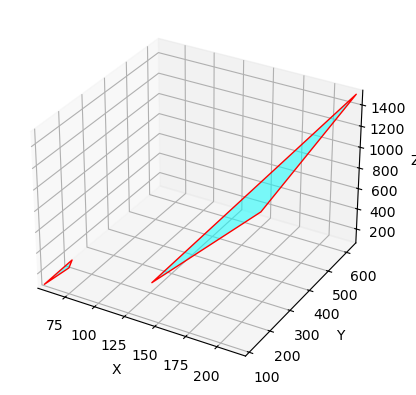

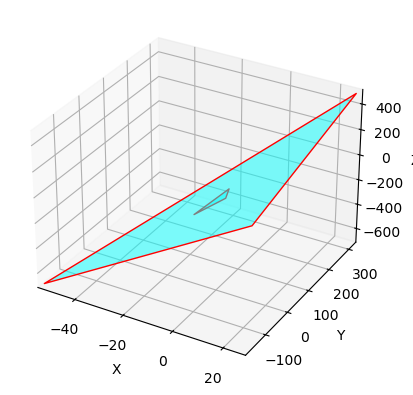

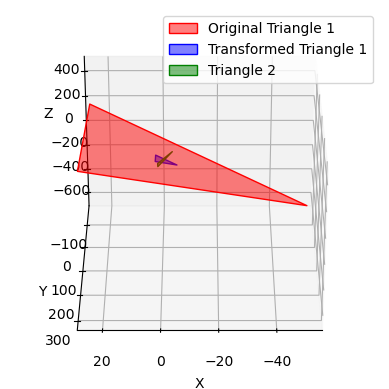

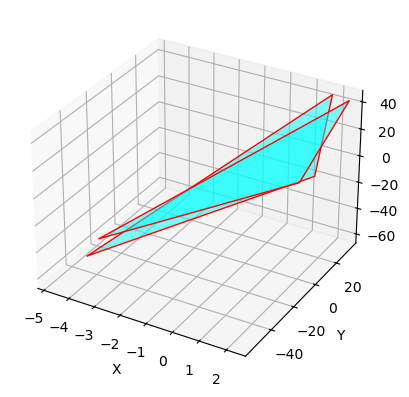

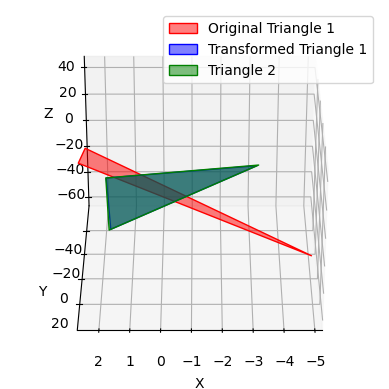

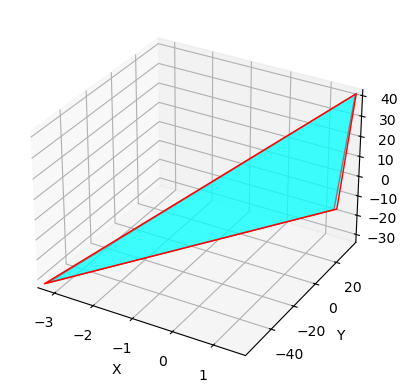

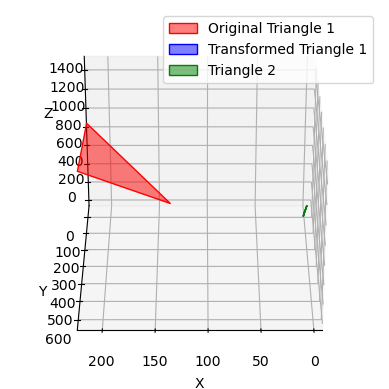

In [12]:
ptsA = np.array([[ 60.        , 191.22101449, 164.23929854],
       [ 60.        , 176.6127111 , 114.1536869 ],
       [ 55.        ,  94.01705596,  90.29902962]])
ptsB = np.array([[ 219.        ,  640.63768116, 1507.1884058 ],
       [ 219.        ,  166.37681159, 1220.28985507],
       [ 138.        ,  137.10144928,  330.31884058]])

centerd_A = centered_coordinates(ptsA)
centerd_B = centered_coordinates(ptsB)

rescaled_B, scale_factor = rescale_dimensions(centerd_A, centerd_B, AmatchB=False)
rotation_matrix = kabsch_algorithm(rescaled_B, centerd_A)
rotated_B = np.dot(rescaled_B, rotation_matrix)

visualize_triangles([ptsA, ptsB])
visualize_triangles([centerd_A, centerd_B])
animate_plot_triangles(centerd_B, rescaled_B, centerd_A, "rescale_at_origin.gif")
visualize_triangles([centerd_A, rescaled_B])
animate_plot_triangles(rescaled_B, rotated_B, centerd_A, "transform_at_origin.gif")
visualize_triangles([centerd_A, rotated_B])

animate_plot_triangles(ptsB, rotated_B, centerd_A, "original_transformed.gif")


In [3]:
lami2ide = load_tiff_images_to_array("/Users/marinf/conda/stackalign/2ide_data")
lami2bm = load_tiff_images_to_array("/Users/marinf/conda/stackalign/2bm_data")


ptsA = np.array([[ 60.        , 191.22101449, 164.23929854],
       [ 60.        , 176.6127111 , 114.1536869 ],
       [ 55.        ,  94.01705596,  90.29902962]])
ptsB = np.array([[ 219.        ,  640.63768116, 1507.1884058 ],
       [ 219.        ,  166.37681159, 1220.28985507],
       [ 138.        ,  137.10144928,  330.31884058]])

#transoform B to match A;2BM to match 2ide
transformed_triangleB, R, T, scale_factor, centroidB, centroidA = align_triangles(ptsB, ptsA)

tranaformed_img = apply_rotation_matrix(lami2bm, R)
theta_x, theta_y, theta_z = rotation_matrix_to_euler_angles(R)
print("Theta_x (degrees):", np.degrees(theta_x))
print("Theta_y (degrees):", np.degrees(theta_y))
print("Theta_z (degrees):", np.degrees(theta_z))

#this will be useful later:
pts_cent_diff = transformed_triangleB - centroidA




In [24]:
pts_cent_diff = transformed_triangleB - centroidA
#translate point centroid coordinates to image coordinates
centroidB_imgcoords = np.round(np.array([centroidB[0], lami2bm.shape[1]-centroidB[1], lami2bm.shape[2]-centroidB[2]])).astype(int)
centroidA_imgcoords = np.round(np.array([centroidA[0], lami2ide.shape[1]-centroidA[1], lami2ide.shape[2]-centroidA[2]])).astype(int)


In [ ]:
#calculate distance of centroid from center of 3D volume
z = np.round(lami2bm.shape[0]//2-centroidB_imgcoords[0]).astype(int)
y = np.round(lami2bm.shape[1]//2-centroidB_imgcoords[1]).astype(int)
x = np.round(lami2bm.shape[2]//2-centroidB_imgcoords[2]).astype(int)
dist_from_center_img = np.array([z,y,x]) #how much you need to  shift image stack by to place centroid at center of volume. 


#need to add padding to stack1 so that features do not roll off the volume cube
# and calculate coordinates of centroid accounting for added padding 
padded_lami2bm = np.zeros(lami2bm.shape+(2*np.abs(dist_from_center_img)))
padded_lami2bm = insert_array_in_center(padded_lami2bm,lami2bm)
padded_centroid_coords = np.array([padded_lami2bm.shape[0]//2 - dist_from_center_img[0], 
                         padded_lami2bm.shape[1]//2 - dist_from_center_img[1],   
                         padded_lami2bm.shape[2]//2 - dist_from_center_img[2]])


#need to move image stack such that it's new_centroid is at center of volume prior to scaling and applying rotation matrix 
translated_lami2bm = apply_translation_to_image_stack(padded_lami2bm,z,y,x)
translated_centroid = padded_centroid_coords+dist_from_center_img

# Step 2: Scale stack1 based on scaling factor calculated from triangle_alingment
scaling = tuple(np.round(np.array(translated_lami2bm.shape)*scale_factor).astype(int))
downscaled_lami2bm = resize(translated_lami2bm, scaling, mode='constant', anti_aliasing=True)
downscaled_centroid = np.round(translated_centroid*scale_factor).astype(int)

# Step 2.25:find new centroid after padding downscaled stack to match stack2 dimensions
expanded_vol_center =np.array(lami2ide.shape)//2
center_centroid_diff = expanded_vol_center- downscaled_centroid
new_centroid = downscaled_centroid + center_centroid_diff

#step 2.5: place downscaled stack1 at the center of empty volume of dimensions(stack2)
expanded_lami2bm = np.zeros_like(lami2ide)
expanded_lami2bm = insert_array_in_center(expanded_lami2bm, downscaled_lami2bm)

# Step 3: Apply the rotation to scaled_stack1
rotated_lami2bm = apply_rotation_matrix(expanded_lami2bm, R)
#applying rotation matrix to centroid not necessary since it will still be at the center. 

# Step 3.5: find the translation vector to move stack1 to stak2 centroid positions
centroidA_imgcoords = np.round(np.array([centroidA[0], lami2ide.shape[1]-centroidA[1], lami2ide.shape[2]-centroidA[2]])).astype(int)
c_diffs = centroidA_imgcoords-new_centroid

#  step 4: Translate rotated_stack1 back to the position of stack2
transformed_lami2bm = apply_translation_to_image_stack(rotated_lami2bm,c_diffs[0], c_diffs[1], c_diffs[2])
transformed_centroid = new_centroid + c_diffs

transformed_ptsB = transformed_triangleB
transformed_ptsB[:,0] = np.round(transformed_ptsB[:,0]).astype(int)
imgB = transformed_lami2bm[24]/np.max(transformed_lami2bm[24])*255 
imgA = lami2ide[24]/np.max(lami2ide[24])*255
overlay = imgB-imgA

In [ ]:
# visualize_image_with_scatter(transformed_lami2bm[24], points=[tuple(transformed_ptsB[0,1:]), tuple(transformed_ptsB[1,1:]), tuple(transformed_ptsB[2,1:])], title="Image", cmap='gray', marker_size=50)
# visualize_image_with_scatter(transformed_lami2bm[22], points=[tuple(transformed_ptsB[2,1:])], title="Image", cmap='gray', marker_size=50)
# 
# visualize_image_with_scatter(lami2ide[24], points=[tuple(ptsA[0,1:]), tuple(ptsA[1,1:]), tuple(ptsA[2,1:])], title="Image", cmap='gray', marker_size=50)
# visualize_image_with_scatter(lami2ide[22], points=[tuple(ptsA[2,1:])], title="Image", cmap='gray', marker_size=50)
# 
# overlay = overlay_images(imgA, imgB, channel1 = "red", channel2= "green")
# visualize_image_with_scatter(overlay, points=[tuple(ptsA[0,1:]), tuple(ptsA[1,1:]), tuple(ptsA[2,1:])], title="Image", cmap='gray', marker_size=50)

In [ ]:
                #save indiv inmages
# for i in range(self.stack_left.imgs.shape[0]):
#     img = self.stack_right.imgs[i].astype(np.float32)
#     formatted_number = f"{i:04}"
#     imageio.imwrite(f'/Users/marinf/conda/stackalign/2ide_S1_overview_20um_Focus/2ide_{formatted_number}.tiff', img)
# for i in range(self.stack_right.imgs.shape[0]):
#     img = self.stack_right.imgs[i].astype(np.float32)
#     formatted_number = f"{i:04}"
#     imageio.imwrite(f'/Users/marinf/conda/stackalign/2bm_dowsnscaled/2bm_{formatted_number}.tiff', img)

#                 # save as tiff stack
#                 imageio.mimwrite(f'/Users/marinf/conda/stackalign/lami2ide.tiff', self.stack_left.imgs.astype(np.float32), format='TIFF')
#                 imageio.mimwrite(f'/Users/marinf/conda/stackalign/lami2bm.tiff', self.stack_right.imgs.astype(np.float32), format='TIFF')


In [5]:
# Step 3: Apply the rotation to scaled_stack1
R2 = rotation_matrix_from_angles(100, -7.614750914315949, -175.4495067449307)
rotated_lami2bm = apply_rotation_matrix(expanded_lami2bm, R2)
#applying rotation matrix to centroid not necessary since it will still be at the center. 

# Step 3.5: find the translation vector to move stack1 to stak2 centroid positions
centroidA_imgcoords = np.round(np.array([centroidA[0], lami2ide.shape[1]-centroidA[1], lami2ide.shape[2]-centroidA[2]])).astype(int)
c_diffs = centroidA_imgcoords-new_centroid

#  step 4: Translate rotated_stack1 back to the position of stack2
transformed_lami2bm = apply_translation_to_image_stack(rotated_lami2bm,c_diffs[0], c_diffs[1], c_diffs[2])
transformed_centroid = new_centroid + c_diffs

transformed_ptsB = transformed_triangleB
transformed_ptsB[:,0] = np.round(transformed_ptsB[:,0]).astype(int)
imgB = transformed_lami2bm[24]/np.max(transformed_lami2bm[24])*255 
imgA = lami2ide[24]/np.max(lami2ide[24])*255
overlay = imgB-imgA

visualize_image_with_scatter(transformed_lami2bm[24], points=[tuple(transformed_ptsB[0,1:]), tuple(transformed_ptsB[1,1:]), tuple(transformed_ptsB[2,1:])], title="Image", cmap='gray', marker_size=50)
# visualize_image_with_scatter(transformed_lami2bm[22], points=[tuple(transformed_ptsB[2,1:])], title="Image", cmap='gray', marker_size=50)
# 
visualize_image_with_scatter(lami2ide[24], points=[tuple(ptsA[0,1:]), tuple(ptsA[1,1:]), tuple(ptsA[2,1:])], title="Image", cmap='gray', marker_size=50)
# visualize_image_with_scatter(lami2ide[22], points=[tuple(ptsA[2,1:])], title="Image", cmap='gray', marker_size=50)
# 
# overlay = overlay_images(imgA, imgB, channel1 = "red", channel2= "green")
visualize_image_with_scatter(overlay, points=[tuple(ptsA[0,1:]), tuple(ptsA[1,1:]), tuple(ptsA[2,1:])], title="Image", cmap='gray', marker_size=50)


In [ ]:
#save indiv inmages
# for i in range(self.stack_left.imgs.shape[0]):
#     img = self.stack_right.imgs[i]
#     formatted_number = f"{i:04}"
#     imageio.imwrite(f'/Users/marinf/conda/stackalign/2ide_S1_overview_20um_Focus/2ide_{formatted_number}.tiff', img)
# for i in range(self.stack_right.imgs.shape[0]):
#     img = self.stack_right.imgs[i]
#     formatted_number = f"{i:04}"
#     imageio.imwrite(f'/Users/marinf/conda/stackalign/2bm_dowsnscaled/2bm_{formatted_number}.tiff', img)




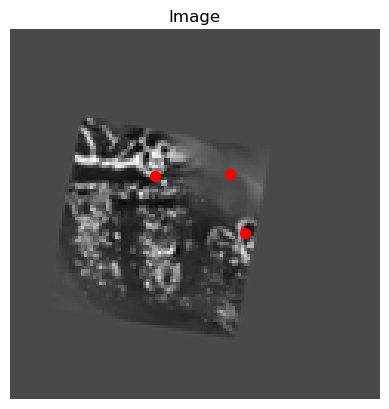

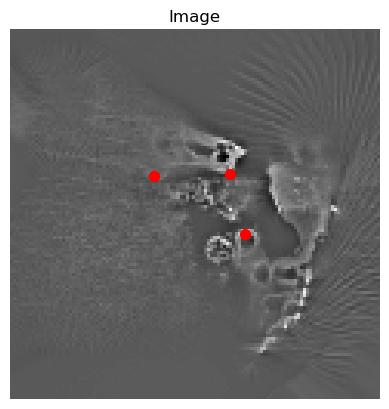

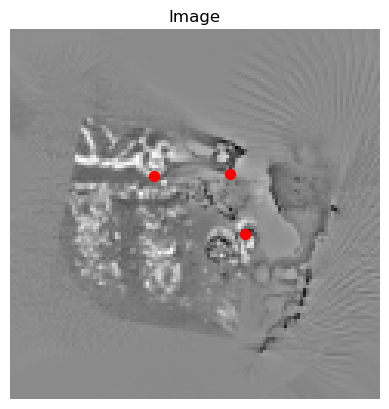

In [6]:
import imageio
for i, img in enumerate(transformed_lami2bm):
    formatted_number = f"{i:04}"
    imageio.imwrite('output_image_2d.tiff', array_2d)

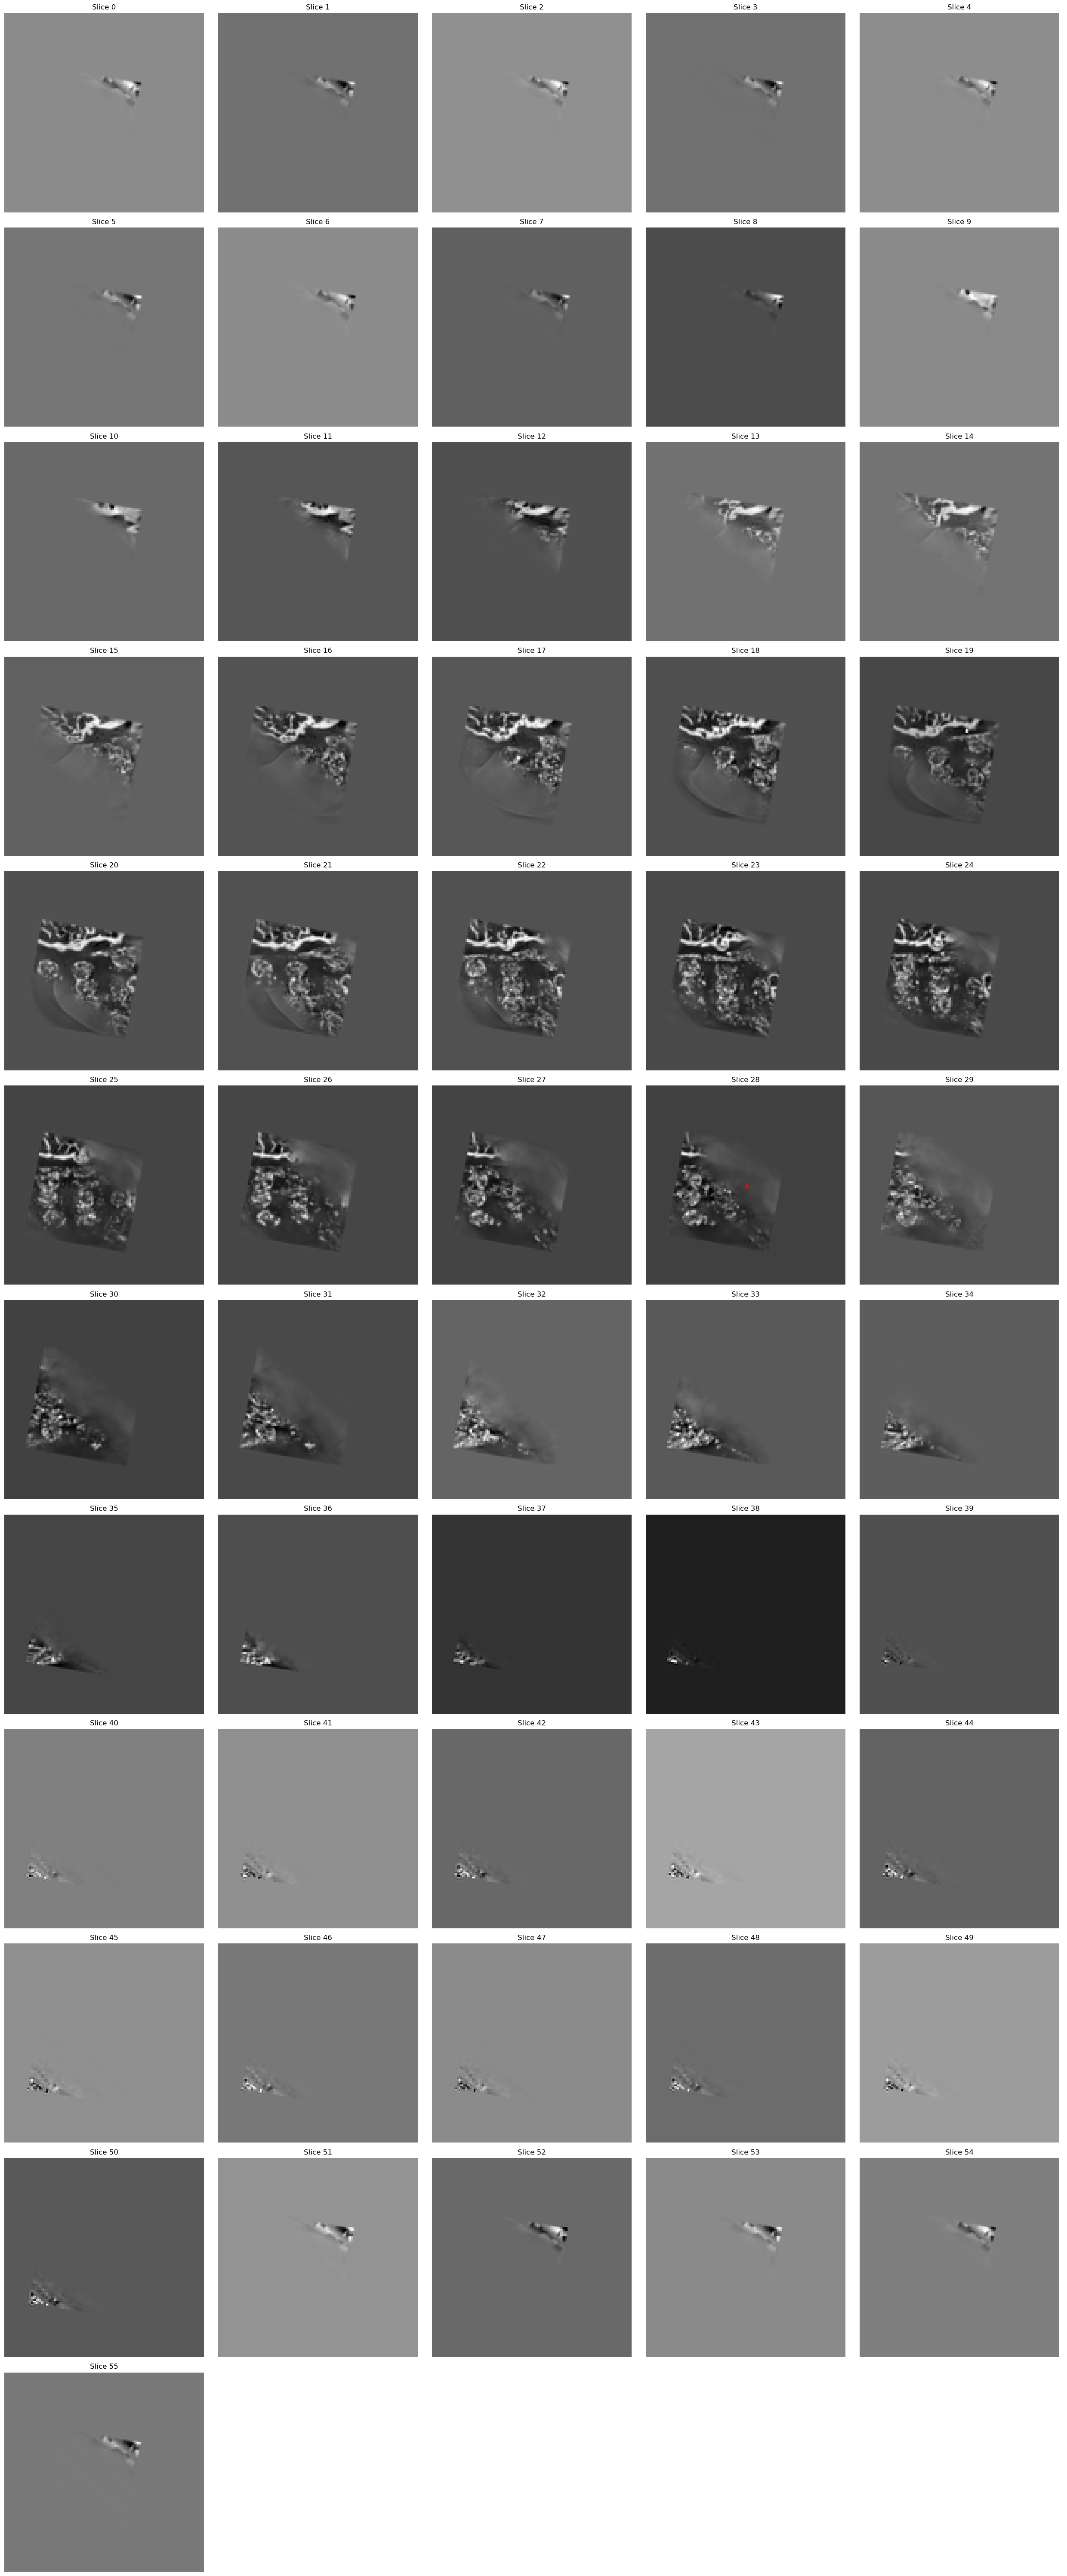

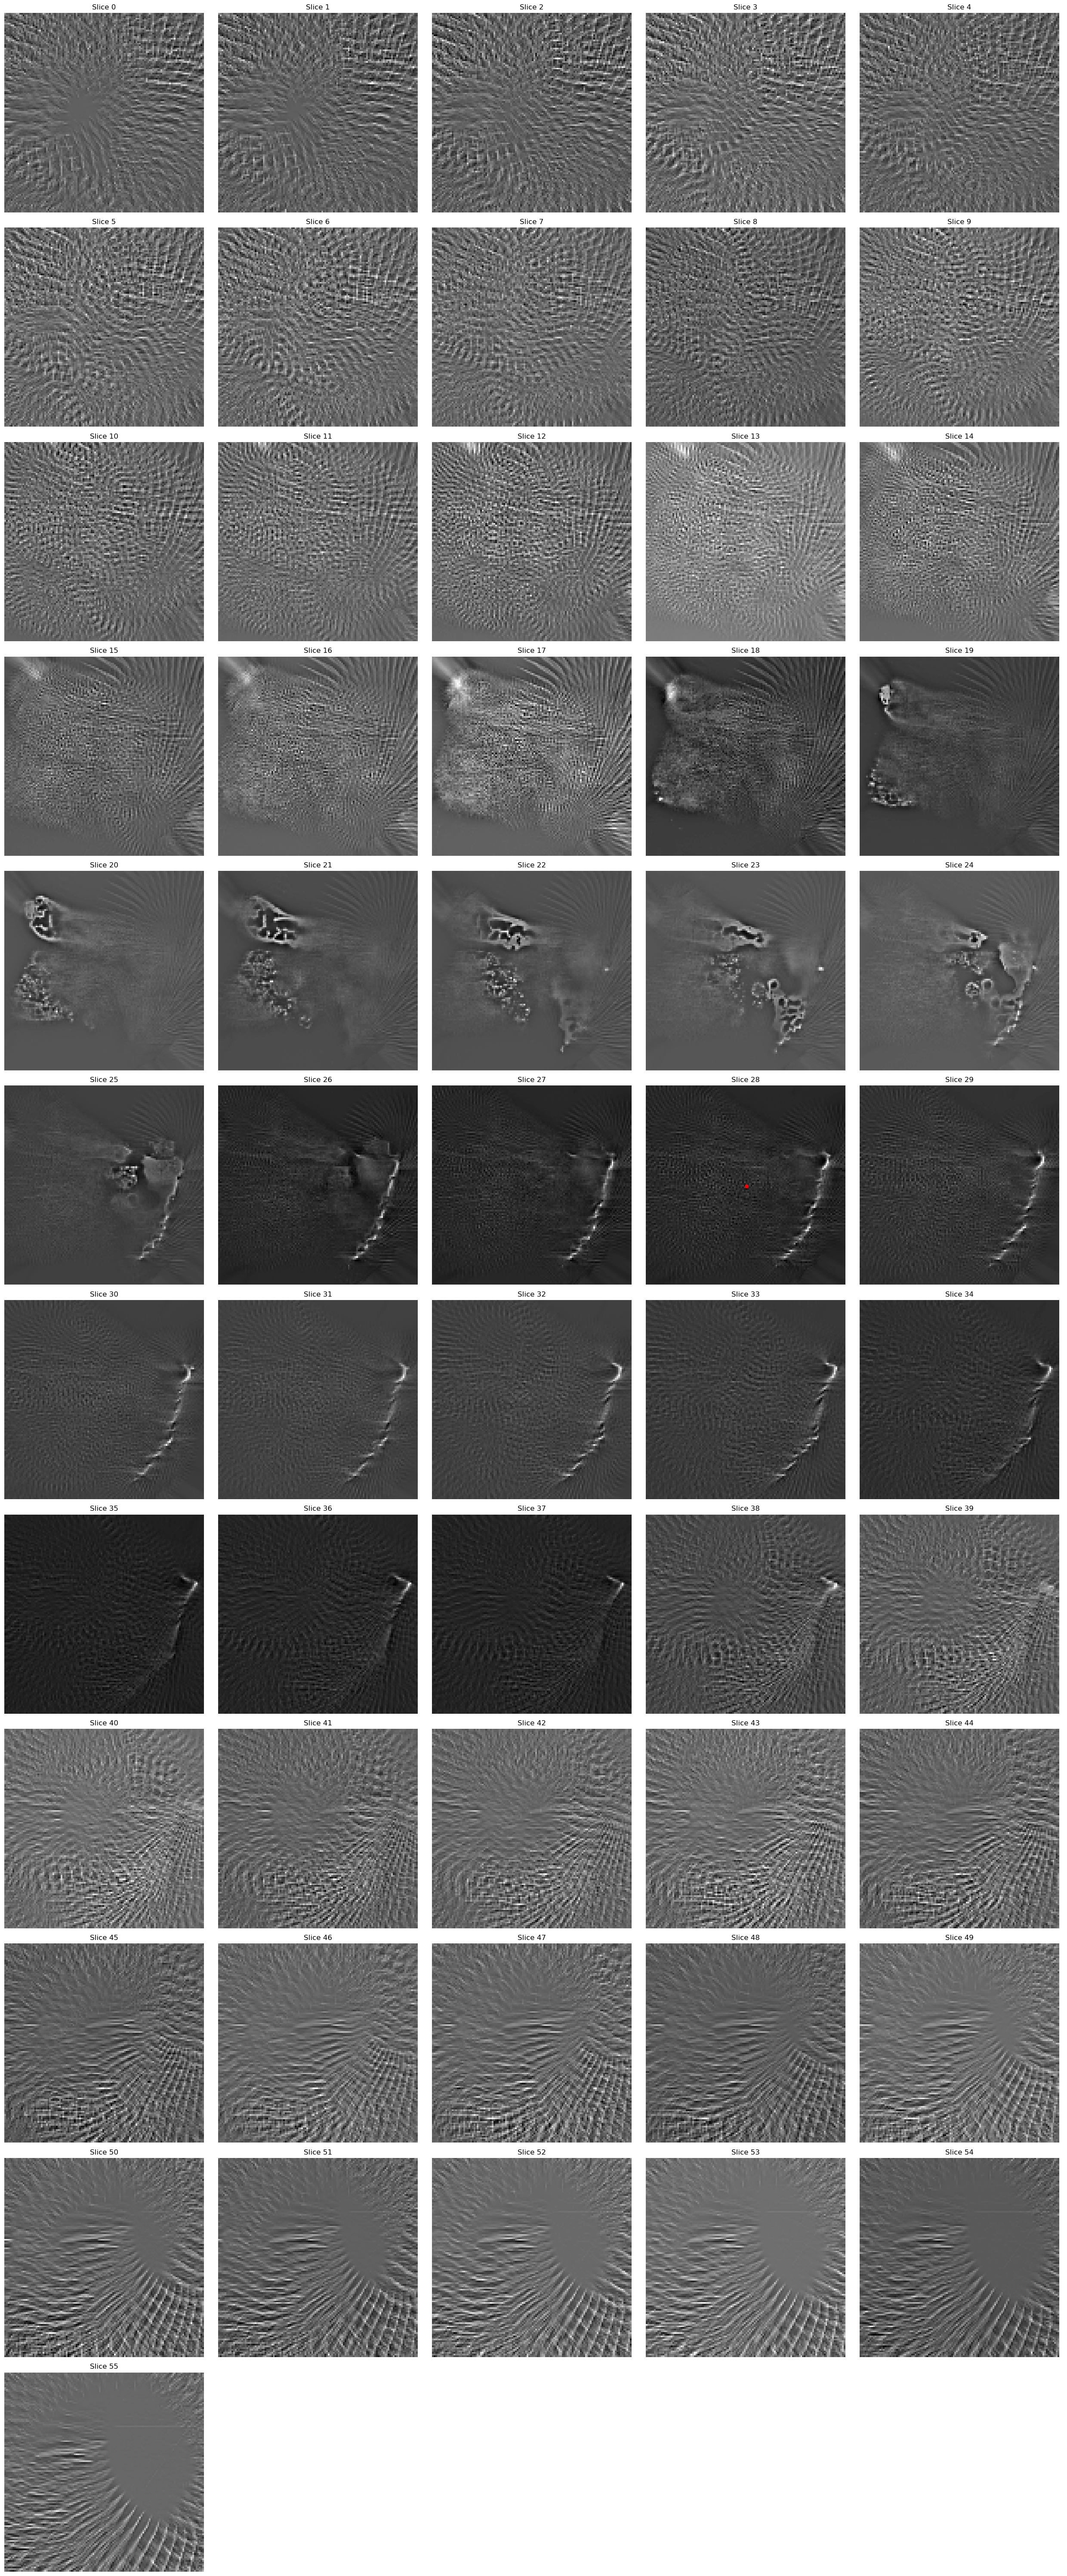

In [57]:
visualize_image_stack_all_at_once(transformed_lami2bm)
visualize_image_stack_all_at_once(lami2ide)

